In [1]:
# import os
import sys
from pathlib import Path

# module_path = os.path.abspath(os.path.join('../'))
# if module_path not in sys.path:
#     sys.path.append(module_path)

import json
import pickle
import numpy as np
import pandas as pd
import trackpy as tp
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage.measure import regionprops
import skimage.morphology as morph

sys.path.append("code/preprocessing/")
from utils.file_handling import *
from utils.segment3D import get_voxel_size_35mm
from utils.segment2D import get_pixel_size

sys.path.append("code/analysis/utils")
#from data_class import SegmentationData

In [2]:
diff_lim = 0.3
dataset  = "holomonitor_20240301_B1-4"
use_config = False

pix_to_um = get_pixel_size()

In [3]:
im_areas  = np.load(f"data/experimental/processed/{dataset}/im_cell_areas.npy")
#raw_im_areas  = np.load(f"data/experimental/processed/{dataset}/raw_im_cell_areas.npy")
config = json.load(open(f"data/experimental/configs/{dataset}.json"))
im_height = import_stack(f"data/experimental/raw/{dataset}/", config)

microscope = Path(dataset).stem.split("_")[0]
microscope

cellprops = [regionprops(im_areas[i], im_height[i]) for i in range(len(im_areas))]
#raw_cellprops = [regionprops(raw_im_areas[i], im_height[i]) for i in range(len(raw_im_areas))]

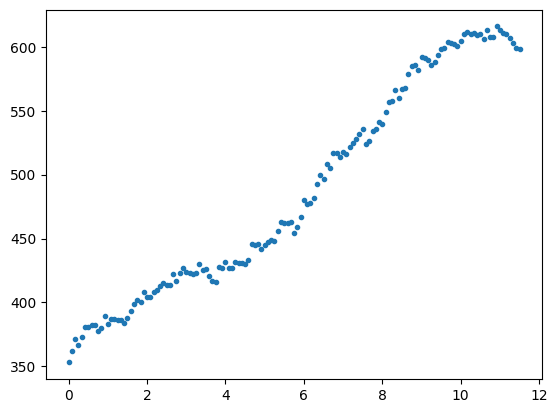

In [4]:
Ncells = [len(cells) for cells in cellprops]
Acells = [[cell.area for cell in cells] for cells in cellprops]
hcells = [[cell.mean_intensity for cell in cells] for cells in cellprops]
Lcells = [[cell.label for cell in cells] for cells in cellprops]
Fcells = [[frame for cell in cellprops[frame]] for frame in range(len(cellprops))]

Acells = np.concatenate(Acells)
hcells = np.concatenate(hcells)
Lcells = np.concatenate(Lcells)
Fcells = np.concatenate(Fcells)

hour = np.arange(len(cellprops)) / 12
plt.plot(hour, Ncells, '.')


Frame 138: 598 trajectories present.


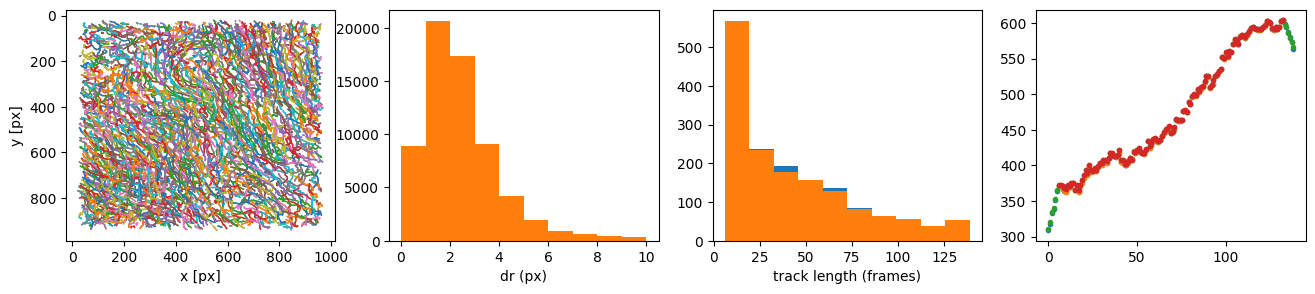

In [ ]:
pos_cells = np.concatenate([[cell.centroid_weighted for cell in cells] for cells in cellprops])

cells_df = pd.DataFrame({'x': pos_cells.T[1],# * pix_to_um[0],
                         'y': pos_cells.T[0],# * pix_to_um[0],
                         'area': Acells * pix_to_um[0]**2,
                         'hmean': hcells,
                         'label': Lcells, 
                         'frame': Fcells})

thres = 6
search_range = 10
tracks = tp.link(cells_df, search_range=search_range, memory=5);
tracks = tp.filter_stubs(tracks, threshold=thres);

dr = np.sqrt(tracks.groupby('particle')['x'].diff()**2 + tracks.groupby('particle')['y'].diff()**2).values
track_length = [np.sum(tracks['particle'] == p_id) for p_id in np.unique(tracks['particle'])]
Ncells = [np.sum(tracks['frame'] == f) for f in np.unique(tracks.frame)]

frames = np.arange(thres, len(Ncells)-thres)

fig, ax = plt.subplots(1,4, figsize=(16,3))
tp.plot_traj(tracks, ax=ax[0])
ax[1].hist(dr)
ax[2].hist(track_length);
ax[3].plot(Ncells, '.', label=thres)
ax[3].plot(frames, Ncells[thres:-thres], '.', label=thres)

ax[1].set(xlabel="dr (px)")
ax[2].set(xlabel="track length (frames)")

tracks = tracks[(tracks.frame >=(thres-1)) * (tracks.frame < np.max(tracks.frame)+1-(thres-1))]


In [257]:
im_tracked = np.copy(im_areas)[5:-4]

for i in range(len(im_tracked)):
    labels = tracks[tracks.frame==5+i].label.values
    exclude = np.setdiff1d(np.unique(im_areas[i]), labels)

    for cell in exclude:
        mask = im_tracked[i] == cell
        im_tracked[i][mask] = 0

In [269]:
np.save(f"data/experimental/processed/{dataset}/im_cell_areas_tracked.npy", im_tracked)

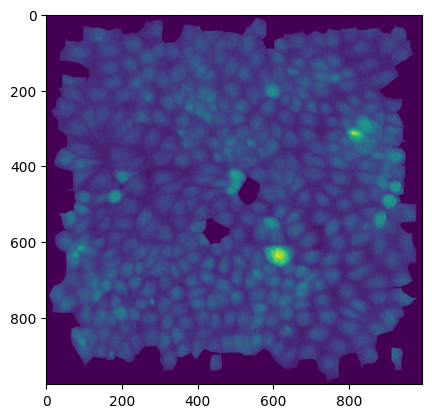

In [267]:
i = 4
plt.imshow((im_tracked[i]>0)*im_height[5+i])

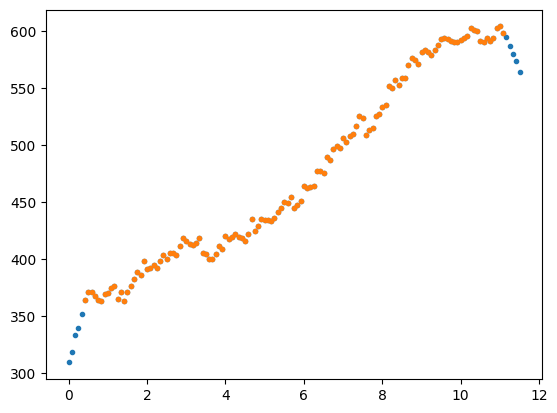

In [ ]:
x_raw = tracks.pivot(index='frame', columns='particle', values='x').to_numpy()
y_raw = tracks.pivot(index='frame', columns='particle', values='y').to_numpy()
A_raw = tracks.pivot(index='frame', columns='particle', values='area').to_numpy() * pix_to_um[1]**2
h_raw = tracks.pivot(index='frame', columns='particle', values='hmean').to_numpy()
l_raw = tracks.pivot(index='frame', columns='particle', values='label').to_numpy()

x_raw = np.ma.masked_where(np.isnan(x_raw), x_raw)
y_raw = np.ma.masked_where(np.isnan(y_raw), y_raw)
A_raw = np.ma.masked_where(np.isnan(A_raw), A_raw)
h_raw = np.ma.masked_where(np.isnan(h_raw), h_raw)
l_raw = np.ma.masked_where(np.isnan(l_raw), l_raw)
V_raw = h_raw * A_raw


plt.plot(hour, Ncells, '.')
plt.plot(hour[5:-5], np.sum(x_raw.mask==0, axis=1), '.')

(None, np.float64(781.880461277326))

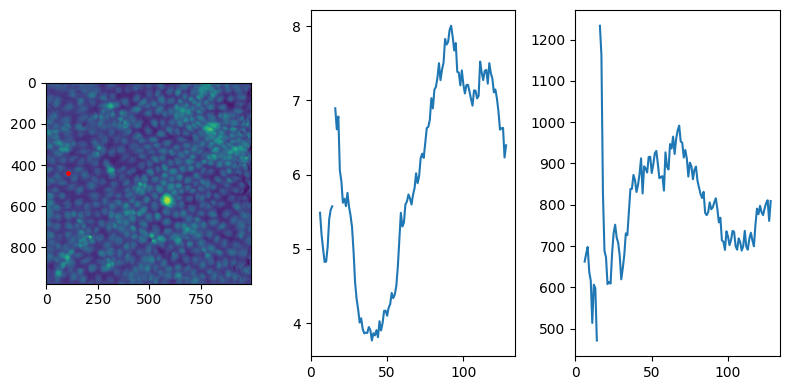

In [231]:
frame = 50
p = 400
plt.figure(figsize=(8,4))
plt.subplot(131)
plt.imshow(im_height[frame+thres-1])
plt.plot(x_raw[frame,p], y_raw[frame,p], 'r.', ms=5)
#plt.plot(x[frame,p], y[frame,p], 'k.', ms=3)

plt.subplot(132)
plt.plot(h_raw[:,p], '-')
#plt.xlim(0, len(A_raw))
#plt.ylim(np.min(A_raw), np.max(A_raw))
#plt.plot(V.data[:,p] * V.mask[:,p], '.')
#plt.plot(V.data[:,p][abs(1 - V.data[:,p] / np.ma.median(np.nan_to_num(V.data[:,p]))) < 0.3] , '.')


plt.subplot(133)
plt.plot(V_raw[:,p],'-')


plt.tight_layout(), np.ma.median(np.nan_to_num(V.data[:,p]))

In [ ]:
plt.figure(figsize=(8,3))
plt.subplot(131)
plt.title("dh / h")
plt.hist((np.ma.diff(h_raw, axis=0) / h_raw[:-1]).flatten(), bins=40);
plt.yscale("log")

plt.subplot(132)
plt.title("dA / A")
plt.hist((np.ma.diff(A_raw, axis=0) / A_raw[:-1]).flatten(), bins=40);
#plt.hist((np.ma.diff(h, axis=0) / h[:-1]).flatten(), bins=40);
plt.yscale("log")

plt.subplot(133)
plt.title("dr (µm)")
plt.hist(np.sqrt(np.ma.diff(x_raw, axis=0)**2 + np.ma.diff(y_raw, axis=0)**2).flatten() * pix_to_um[1], bins=40)

plt.tight_layout()

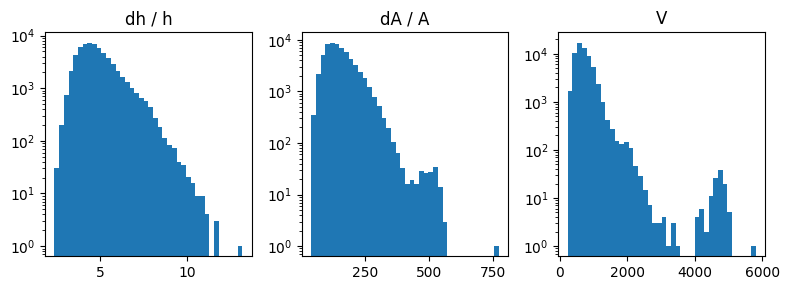

In [134]:
plt.figure(figsize=(8,3))
plt.subplot(131)
plt.title("dh / h")
plt.hist(h_raw.flatten(), bins=40);
plt.yscale("log")

plt.subplot(132)
plt.title("dA / A")
plt.hist(A_raw.flatten(), bins=40);
#plt.hist((np.ma.diff(h, axis=0) / h[:-1]).flatten(), bins=40);
plt.yscale("log")

plt.subplot(133)
plt.title("V")
plt.hist(A_raw.flatten() * h_raw.flatten(), bins=40);
plt.yscale("log")

plt.tight_layout()

[False False False ... -- -- --]


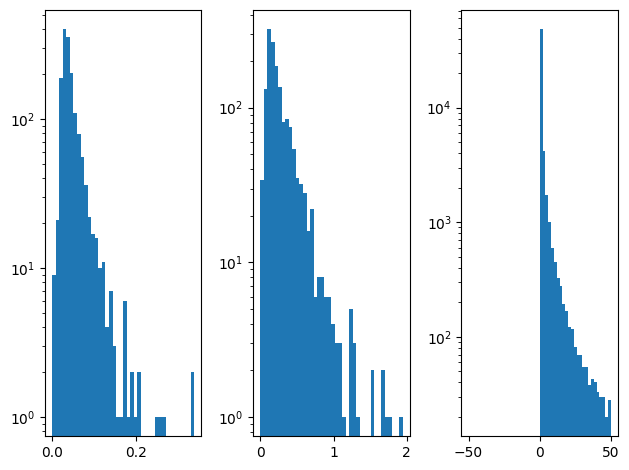

In [135]:
#mask = (h_raw > 11) | (A_raw > 600) | (V_raw > 4000)
dV = abs(np.diff(V_raw, axis=0) / V_raw[:-1])
mask = np.max(dV, axis=0) > 0.3
print(mask)

h = np.ma.copy(h_raw)
h.mask[:] += mask

A = np.ma.copy(A_raw)
A.mask[:] += mask

V = np.ma.copy(V_raw)
V.mask[:] += mask

x = np.ma.copy(x_raw)
x.mask[:] += mask

y = np.ma.copy(y_raw)
y.mask[:] += mask
np.sum(mask)


plt.subplot(131)
plt.hist(np.ma.median(dV, axis=0), bins=40)
plt.yscale("log")

plt.subplot(132)
plt.hist(np.max(abs((dV)), axis=0).flatten(), bins=40)
plt.yscale("log")

plt.subplot(133)
plt.hist((abs(dV - np.ma.median(dV, axis=0)[np.newaxis])/dV).flatten(), bins=50, range=(-50,50))
plt.yscale("log")

plt.tight_layout()

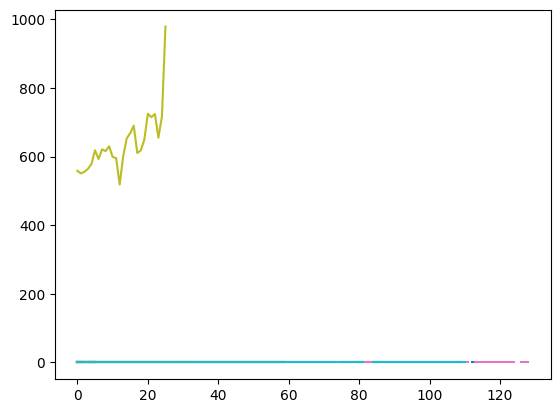

In [136]:
plt.plot(V.data[:,0:10] * V.mask[:,0:10], '-')

(None, np.float64(852.4883618956216))

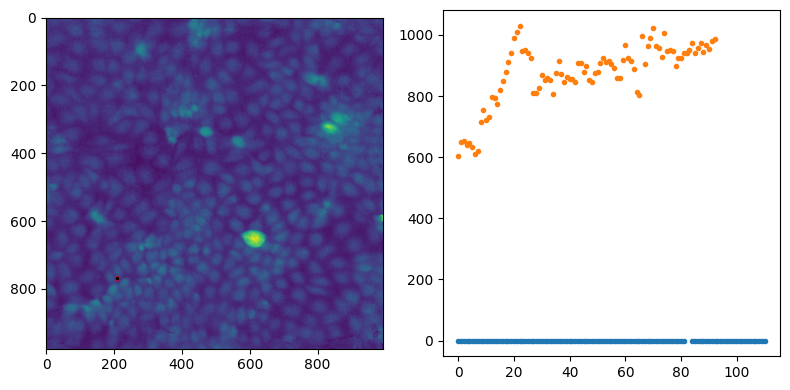

In [137]:
frame = 0
p = 9

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(im_height[frame])
plt.plot(x_raw[frame,p], y_raw[frame,p], 'r.', ms=5)
plt.plot(x[frame,p], y[frame,p], 'k.', ms=3)

plt.subplot(122)
plt.plot(V.data[:,p] * V.mask[:,p], '.')
plt.plot(V.data[:,p][abs(1 - V.data[:,p] / np.ma.median(np.nan_to_num(V.data[:,p]))) < 0.3] , '.')


plt.tight_layout(), np.ma.median(np.nan_to_num(V.data[:,p]))

In [471]:
abs(V.data[:,p] - np.ma.median(np.nan_to_num(V.data[:,p]))) / V.data[:,p] > 0.5

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True, False, False, False,  True,  True,  True,  True,
        True, False,

In [287]:
h_cmap = sns.color_palette("Blues",   as_cmap=True)
e_cmap = mpl.colors.ListedColormap(['none', 'w'])

h_mean = np.zeros_like(im_areas[frame], dtype=np.float64)
h_raw = np.zeros_like(im_areas[frame], dtype=np.float64)
e_im   = np.zeros_like(im_areas[frame], dtype=int)

for cell in cellprops[frame]:

    # isolate cell
    cell_mask = (im_areas[frame] == cell.label)

    # cell heights
    h_raw[cell_mask] = cell.mean_intensity

    # cell edges
    cell_interior = morph.erosion(cell_mask, footprint=morph.disk(1))
    edge = cell_mask ^ cell_interior
    e_im += edge

    if cell.label not in l_raw[frame]:
        continue

    # cell heights
    h_mean[cell_mask] = cell.mean_intensity


e_im += (h_raw == 0)

<Axes: >

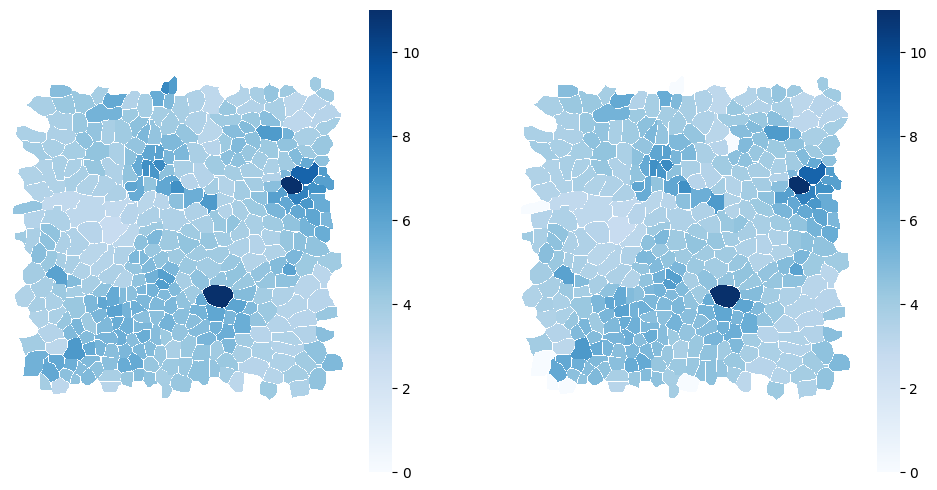

In [288]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

sns.heatmap(h_raw, ax=ax[0], square=True, cmap=h_cmap, vmin=0, vmax=11, xticklabels=False, yticklabels=False, cbar=True)
sns.heatmap(e_im, ax=ax[0], cmap=e_cmap,  xticklabels=False, yticklabels=False, cbar=False)
#ax.set(title=f"Average cell height (µm)")

sns.heatmap(h_mean, ax=ax[1], square=True, cmap=h_cmap, vmin=0, vmax=11, xticklabels=False, yticklabels=False, cbar=True)
sns.heatmap(e_im, ax=ax[1], cmap=e_cmap,  xticklabels=False, yticklabels=False, cbar=False)
#ax.set(title=f"Average cell height (µm)")

In [ ]:

Ncells_new = [len(cells) for cells in cellprops_new]
Acells_new = [[cell.area for cell in cells] for cells in cellprops_new]
hcells_new = [[cell.mean_intensity for cell in cells] for cells in cellprops_new]
Lcells_new = [[cell.label for cell in cells] for cells in cellprops_new]
Fcells_new = [[frame for cell in cellprops_new[frame]] for frame in range(len(cellprops_new))]

Acells_new = np.concatenate(Acells_new)
hcells_new = np.concatenate(hcells_new)
Lcells_new = np.concatenate(Lcells_new)
Fcells_new = np.concatenate(Fcells_new)



hour = np.arange(len(cellprops_new)) / 12
plt.plot(hour, Ncells, '.')
plt.plot(hour, Ncells_new, '.')

0.9746205950441568 0.9762325302237846


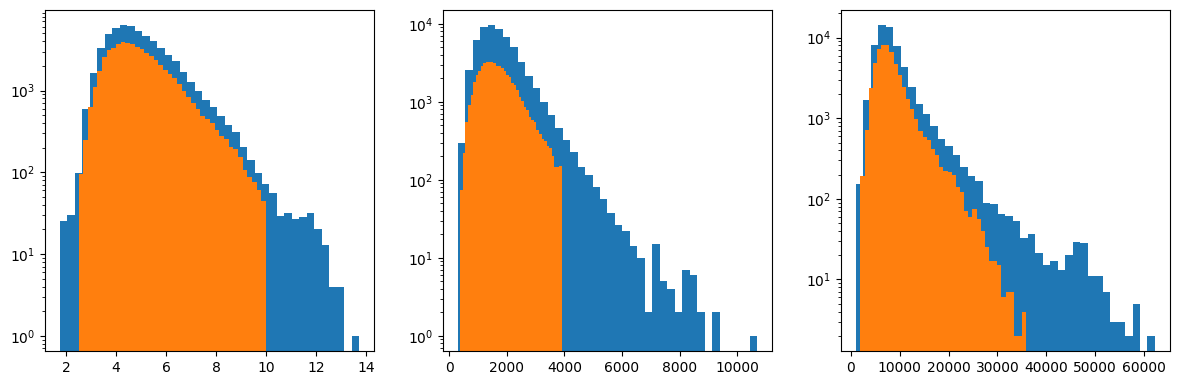

In [648]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].hist(hcells, bins=40)
ax[1].hist(Acells, bins=40)
ax[2].hist(Acells * hcells, bins=40)


remove_small = (hcells > 2.5) * (Acells > 120  / pix_to_um[0]**2) * (Acells * hcells > 600  / pix_to_um[0]**2)
remove_large = (hcells < 10)  * (Acells < 1200 / pix_to_um[0]**2) * (Acells * hcells < 15000 / pix_to_um[0]**2)
#remove_small *= (hcells > 2.5) | (Acells > 600 / pix_to_um[1]**2)

mask = remove_small * remove_large
print(np.sum(mask) / len(Acells), np.sum(remove_large) / len(Acells))

ax[0].hist(hcells[mask], bins=40)
ax[1].hist(Acells[mask], bins=40)
ax[2].hist(Acells[mask] * hcells[mask], bins=40)
plt.tight_layout()

for axes in ax.flatten():
    axes.set(yscale="log")



40
7484.0


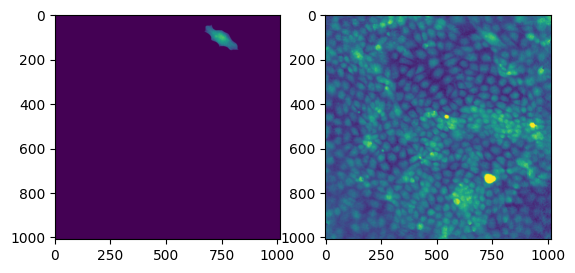

In [650]:
tmp_mask = (Acells * hcells > 15000  / pix_to_um[0]**2) #* (Acells * hcells < 800  / pix_to_um[0]**2)
#plt.imshow(((im_areas[0] == 1) + (im_areas[0] == 2) + (im_areas[0] == 3))* im_height[0])
print(np.sum(tmp_mask))
idx = 30

plt.subplot(121)
plt.imshow(((raw_im_areas[Fcells[tmp_mask][idx]] == Lcells[tmp_mask][idx]))* im_height[Fcells[tmp_mask][idx]], vmin=0, vmax=16)
plt.subplot(122)
plt.imshow(im_height[Fcells[tmp_mask][idx]], vmin=0, vmax=16)

print(Acells[tmp_mask][idx])

(array([ 2.,  1.,  4.,  7., 13., 15.,  3., 10.,  9.,  6.]),
 array([   3. ,  214.5,  426. ,  637.5,  849. , 1060.5, 1272. , 1483.5,
        1695. , 1906.5, 2118. ]),
 <BarContainer object of 10 artists>)

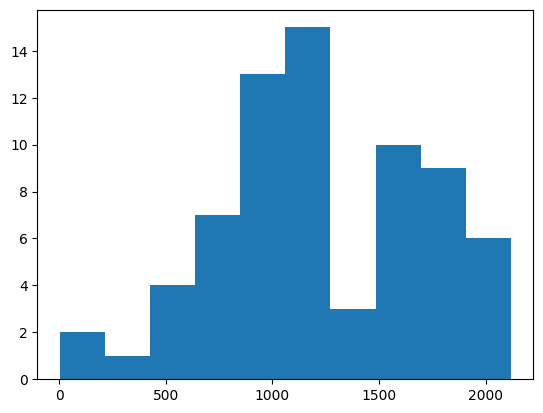

In [437]:
plt.hist(Acells[tmp_mask])

In [ ]:
pos_cells = np.concatenate([[cell.centroid_weighted for cell in cells] for cells in cellprops])

In [655]:
cells_df = pd.DataFrame({'x': pos_cells[mask].T[1],# * pix_to_um[0],
                         'y': pos_cells[mask].T[0],# * pix_to_um[0],
                         'area': Acells[mask] * pix_to_um[0]**2,
                         'hmean': hcells[mask], 
                         'frame': Fcells[mask]})

In [684]:
search_range = 10
tracks = tp.link(cells_df, search_range=search_range, memory=10);
tracks = tp.filter_stubs(tracks, threshold=5);
tracks[tracks.frame == 5].x.values

Frame 20: 386 trajectories present.


array([109.12428781, 471.63450286,  89.20815979, 772.45070529,
       316.08996542,  77.32385697, 359.99543429, 260.69467818,
       176.86541243, 806.85091196, 664.88704157, 101.81210334,
       132.05530749, 635.1749248 , 295.66381037, 474.2555687 ,
       678.56909073, 345.26139736, 122.97278655, 499.90732251,
       651.65264086, 183.92910039, 429.89412014, 324.98340997,
       110.88159048, 545.37853576, 740.11494222, 617.52435787,
       696.52646937, 558.04595421, 745.4418721 , 359.88510906,
       376.70975057,  33.36232369, 553.05298799, 718.65010299,
       755.94709914, 867.11886574, 871.05180839, 904.51493746,
       262.08193005, 465.70209204, 512.29677111, 388.015108  ,
       475.62180487, 723.98065538, 228.1676417 , 252.91495069,
       826.84477745, 381.73668657, 556.5826389 , 639.06562868,
       774.67126833, 656.94173409, 817.53615736, 689.55196249,
       295.93705805, 561.62814374, 250.43590785, 441.55803697,
       815.17096492, 586.41142928, 438.05384607, 842.72

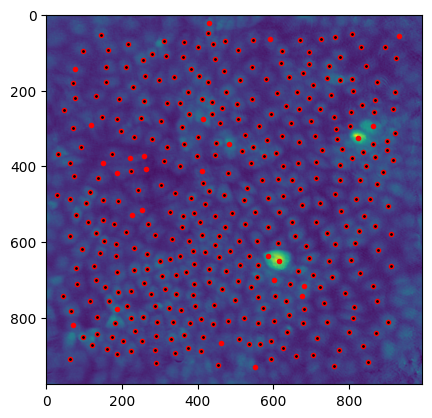

In [680]:
mask = remove_small
i = 4
pos_old = pos_cells[Fcells == i]
pos_new2 = np.array([y_cell[frames == i], x_cell[frames == i]]).T

plt.imshow(im_height[i])
plt.plot(pos_old.T[1], pos_old.T[0], 'r.')
plt.plot(pos_new2.T[1], pos_new2.T[0], 'k.', ms=2)


In [ ]:
fmin = config["segmentation"]["fmin"]
fmax = config["segmentation"]["fmax"]

if microscope == 'holomonitor':
    search_range = 10
    pix_to_um = get_pixel_size()
    h_im = import_holomonitor_stack(f"../../../data/raw/{dataset}", 
                                    f_min=config['segmentation']['fmin'],
                                    f_max=config['segmentation']['fmax'])
    n_im = np.copy(h_im)

elif microscope == 'tomocube':
    search_range = 50
    pix_to_um = get_voxel_size_35mm()
    n_im, h_im = import_tomocube_stack(f"../../../data/raw/{dataset}", 
                                       h_scaling=pix_to_um[0], 
                                       f_min=config['segmentation']['fmin'], 
                                       f_max=config['segmentation']['fmax'])

In [200]:
# set filter parameters
if use_config:

    A_min = config['filtering']['Amin']
    A_max = config['filtering']['Amax']
    V_min = config['filtering']['Vmin']
    V_max = config['filtering']['Vmax']
    h_min = config['filtering']['hmin']
    h_max = config['filtering']['hmax']

else:
    A_min = 100
    A_max = 2000
    V_min = 800
    V_max = 10000
    h_min = 1
    h_max = 18

In [201]:
# create masks
h_mask = (df.h_avrg > h_min) * (df.h_max < h_max) 
A_mask = (df.A > A_min) * (df.A < A_max)
V_mask = (df.V > V_min) * (df.V < V_max)

mask = h_mask * A_mask * V_mask
filtered_df = df[mask]

print(f"Before filtering: {len(df)} cells")
print(f"After filtering:  {len(filtered_df)} cells")

Before filtering: 67479 cells
After filtering:  67350 cells


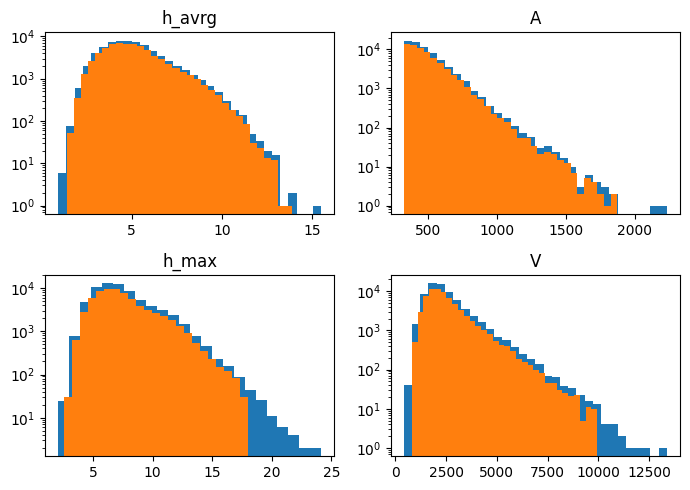

In [202]:
# filter area and volume
fig, ax = plt.subplots(2,2, figsize=(7,5))

ax[0,0].hist(df.h_avrg, bins=32)
ax[0,0].hist(filtered_df.h_avrg,   bins=32)
ax[1,0].hist(df.h_max,  bins=24)#range=(0.5, h_max+0.5), bins=h_max+1)
ax[1,0].hist(filtered_df.h_max,    bins=23)#range=(0.5, h_max+0.5), bins=h_max+1)
ax[0,1].hist(df.A,      bins=32)
ax[0,1].hist(filtered_df.A,        bins=32)
ax[1,1].hist(df.V,      bins=32)
ax[1,1].hist(filtered_df.V,        bins=32)

ax[0,0].set(title="h_avrg", yscale="log")
ax[1,0].set(title="h_max",  yscale="log")
ax[0,1].set(title="A",      yscale="log")
ax[1,1].set(title="V",      yscale="log")
fig.tight_layout()

#fig.savefig(f"{dir}{file}/figs/filter_illustration.png", dpi=100)

In [203]:
# save filter config
config['filtering']["hmin"] = h_min
config['filtering']["hmax"] = h_max
config['filtering']["Amin"] = A_min
config['filtering']["Amax"] = A_max
config['filtering']["Vmin"] = V_min
config['filtering']["Vmax"] = V_max

json.dump(config, open(f"../../../data/configs/{dataset}.json", "w"))

Before: 409
After:  408


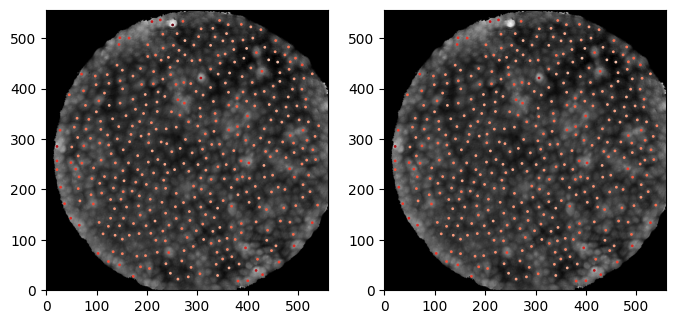

In [ ]:
# verify filtering
idx = 103

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].imshow(n_im[idx].T, origin="lower", cmap="gray", vmin=1.37, extent=[0,pix_to_um[1]*len(h_im[0]), 0, pix_to_um[1]*len(h_im[0,0])]);
ax[1].imshow(n_im[idx].T, origin="lower", cmap="gray", vmin=1.37, extent=[0,pix_to_um[1]*len(h_im[0]), 0, pix_to_um[1]*len(h_im[0,0])]);
ax[0].scatter(df[df.frame==idx].x, df[df.frame==idx].y, s=1, cmap="Reds", c=df[df.frame==idx].h_max, vmin=0, vmax=h_max)#, 'r.', ms=3);
ax[1].scatter(filtered_df[filtered_df.frame==idx].x, filtered_df[filtered_df.frame==idx].y, s=1, cmap="Reds", c=filtered_df[filtered_df.frame==idx].h_max, vmin=0, vmax=h_max)#, 'r.', ms=3);

print(f"Before: {len(df[df.frame==idx])}")
print(f"After:  {len(filtered_df[filtered_df.frame==idx])}")

In [132]:
filtered_areas = np.copy(areas[idx])

for l in range(0, areas[idx].max()):
    if l not in filtered_df[filtered_df.frame==idx].label.values:
        filtered_areas[filtered_areas == l] = 0

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].imshow((h_im[idx]*(areas[idx]>0)).T, origin="lower", cmap="gray", vmin=1.37);
ax[1].imshow((h_im[idx]*(filtered_areas>0)).T, origin="lower", cmap="gray", vmin=1.37);

ax[0].plot(df[df.frame==idx].x, df[df.frame==idx].y, 'r.', ms=2);
ax[1].plot(filtered_df[filtered_df.frame==idx].x, filtered_df[filtered_df.frame==idx].y, 'r.', ms=2);

print(sum(df.frame==idx))

IndexError: index 160 is out of bounds for axis 0 with size 121